<center><h1>Machine Learning-Based Pricing Model for Airbnbs in New York</h1></center>

<h3> Title: Machine Learning-Based Pricing Model for Airbnbs in New York </h3>
<h3> Spring 2024 Data Science Project </h3>
<h3> Authors:  </h3>
<hr style="height:0.01px; visibility:hidden;" />

- Somil Varshney
- Sahil Raju Nilkanthache
- Rishi Modugu
- Elena Rangelov

# **Necessary imports**

In [1]:
import pandas as pd

# machine learning analysis imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import tqdm
import copy
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler

# statistical analysis
from scipy import stats
from scipy.stats import kruskal
from scipy.stats import f_oneway
from scipy.stats import ttest_ind

# data visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# **Introduction**

We chose this topic to find answers for several common perceptions about Airbnb listings and whether those conclusions are justified.

These include questions like:
- **Location Preferences:** By analyzing review sentiments and ratings across different neighborhoods in New York City, the model identifies which areas are most profitable. This information can be valuable for both hosts and guests in making decisions about where to stay or where to list their properties.
- **Price Sensitivity:** Analyzing the relationship between listing prices and review scores can reveal whether guests perceive higher-priced listings as offering better value or if they are more critical of expensive properties. This information can help hosts optimize their pricing strategies.
- **Competitive Analysis:** Comparing review data across different Airbnb listings can help hosts benchmark their performance against competitors and identify areas for improvement. This can include aspects such as pricing, amenities, and overall guest experience.


Our focus is on maximizing profits for hosts and analyzing best deals for guests when traveling. We want hosts in New York to enter features of their Airbnb and get an estimate as to what price they should charge. Also, we want potential airbnb customers to ask our model what price they should pay. Answering the questions above is important because it can save our users money when planning trips to an already very expensive area in New York.


# **Data Curation**

**Source:** https://www.kaggle.com/datasets/manjitbaishya001/airbnb-new-york-jan-2024?select=detailed_reviews.csv, sourced from Airbnb

**Description:** Airbnb data from New York focusing on listings, locations, and user reviews of locations. This dataset includes the reviews for each Airbnb as well as other features like price. Features like neighbourhood group and neighbourhood can be used to estimate the price ranges for certain areas. The type of Airbnb (Rental Unit, Loft, etc.) can also be used to estimate the price. These are the most important features for formulating a pricing model, which is the goal of this project. We also anonymized the data by stripping the names and instead identifying the host based on the host id.

### Data Preprocessing

Here we are cleaning and altering the data to conduct statistical and machine learning analysis more easily in the future.

In [2]:
sns.set_theme()

# Importing dataset and organizing
listings_df = pd.read_csv("./dataset/listings.csv")

# Dropping all listings with a NA price as the percentage of NAs is more than 5%
# Imputation unnecessary because there are enough valid price listings
listings_df = listings_df.dropna(subset=['price'])

# taking out outliers (only 7 listings have prices higher than 19000 and may
# ruin integrity of our dataset)
listings_df = listings_df[listings_df["price"] < 19000.0]

listings_df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
1,743430766348459803,Rental unit in Brooklyn · 1 bedroom · 1 bed · ...,83422715,D,Brooklyn,Flatbush,40.65375,-73.95502,Entire home/apt,289.0,30,0,NaN,NaN,1,365,0,NaN
6,11943,Home in Brooklyn · 1 bedroom · 2 beds · 1 bath,45445,Harriet,Brooklyn,Flatbush,40.63702,-73.96327,Private room,150.0,30,0,NaN,NaN,1,0,0,NaN
8,1312228,Rental unit in Brooklyn · ★5.0 · 1 bedroom,7130382,Walter,Brooklyn,Clinton Hill,40.68371,-73.96461,Private room,55.0,30,3,2015-12-20,0.03,1,0,0,NaN
24,13440481,Rental unit in New York · 1 bedroom · 1 bed · ...,17385374,Dennis J.,Manhattan,Upper East Side,40.76550,-73.97080,Private room,301.0,30,0,NaN,NaN,1,0,0,NaN
28,45277537,Rental unit in New York · ★4.67 · 2 bedrooms ·...,51501835,Jeniffer,Manhattan,Hell's Kitchen,40.76661,-73.98810,Entire home/apt,144.0,30,9,2023-05-01,0.24,139,364,2,NaN


In [10]:
# Drops unnecessary columns due to NA values: license, last_review, id, host_name, name
listings_df.drop(["license", "last_review", "id", "host_name", "name"], axis=1, inplace=True)
print(listings_df.size, (listings_df.dropna()).size)
listings_df = listings_df.dropna()

378183 269854


Resources for the methods used in the block above!
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html

### What We Dropped and Why

We dropped the "license", "last_review", "id", and "host_name" columns.
- License: 90% of the data did not have a license, so when we dropped NAs, it would leave us with 50k users instead of 500k.
- Last Review: There were a ton of NAs, but also we did not need this column for any analysis.
- ID: Since every ID is unique, there is nothing we can do with it. We have row numbers instead.
- Host Name: We wanted to anonymize the data, but also we have host_id which is numerical and allows to easily search for it.

In [11]:
# Encodes necessary categorical columns to corresponding integer values
encoded_data = listings_df.copy(deep=True) 
list_cols_to_encode = ["neighbourhood_group", "neighbourhood", "room_type"] 
# As seen in the data frame listed below, neighbourhood, neighbourhood_group, and room_type are encoded uniquely
for i in list_cols_to_encode: 
    encoded_data[i] = encoded_data[i].replace(encoded_data[i].unique(), [j for j in range(len(encoded_data[i].unique()))]) 
    
encoded_data.head()

/tmp/ipykernel_45295/3827840903.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  encoded_data[i] = encoded_data[i].replace(encoded_data[i].unique(), [j for j in range(len(encoded_data[i].unique()))])


,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
8,0,0,0,55.0,30,3,0.03,1,0,0
28,1,1,1,144.0,30,9,0.24,139,364,2
38,1,2,1,187.0,2,6,1.67,1,343,6
40,1,3,0,120.0,30,156,1.38,2,363,12
45,1,4,1,85.0,30,11,0.24,133,335,3


Resources for the methods used in the block above! https://www.geeksforgeeks.org/how-to-convert-categorical-variable-to-numeric-in-pandas/

# **Exploratory Data Analysis and Summary Statistics**

### Statistical Method #1

**Null Hypothesis ($H_{0}$) :** The neighborhood group of the Airbnb does not have a statistically significant impact on the availability for the Airbnb.

**Alternative Hypothesis ($H_{a}$) :** The neighborhood group of the Airbnb has a statistically significant impact on the availability for the Airbnb.

**Alpha-Value ($a$) :** 0.05

**Confidence level:** 95%

Resource for the method used in the block below! https://www.geeksforgeeks.org/how-to-perform-a-kruskal-wallis-test-in-python/

Kruskal-Wallis Test Statistic: 113.1387129531746
P-Value: 1.5575141906311136e-23
neighbourhood_group
Bronx            237.586934
Staten Island    232.350515
Queens           212.205796
Manhattan        203.919134
Brooklyn         200.200078
Name: availability_365, dtype: float64


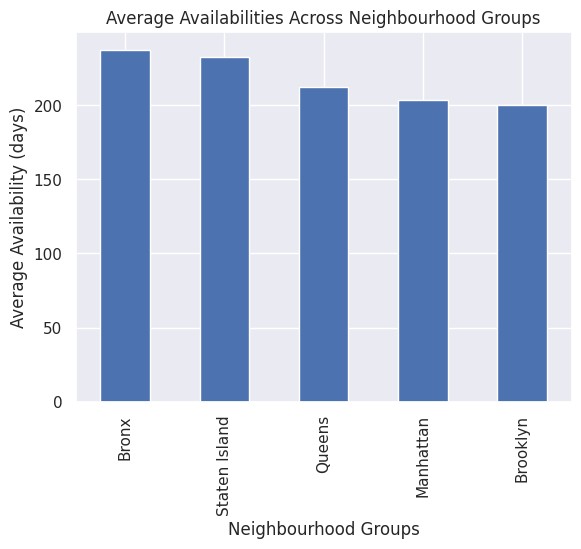

In [12]:
# Group by neighborhood group and calculate mean availability
df_groups = listings_df.groupby('neighbourhood_group')['availability_365'].mean().sort_values(ascending=False)

# Convert mean availability to a list
mean_availability = df_groups.tolist()

# Perform Kruskal-Wallis test to compare mean availability across neighborhood groups
statistic, p = kruskal(*[listings_df[listings_df['neighbourhood_group'] == group]['availability_365'] for group in df_groups.index])

# Prints the average prices of neighbourhood groups in descending order
print("Kruskal-Wallis Test Statistic:", statistic)
print("P-Value:", p)
print(df_groups)

# Plotting the bar graph with necessary labels
df_groups.plot.bar()
plt.ylabel('Average Availability (days)')
plt.xlabel('Neighbourhood Groups')
plt.title('Average Availabilities Across Neighbourhood Groups')
plt.show()

Since the p-value is lower than the confidence interval, we can reject the null hypothesis. This means that the location has a statistically significant impact on the availability for the Airbnb. The most available Airbnbs are located in Staten Island, and the least available Airbnbs are in Brooklyn.

This is important for the machine learning model because the model should take into account that there are disproportionate availabilities based on the location of the Airbnb. The pricing model will weigh this as well.

### Statistical Method #2

**Null Hypothesis ($H_{0}$) :** The neighbourhoods in Manhattan do not have a statistically significant impact on the mean prices for Entire home/apt units.

**Alternative Hypothesis ($H_{a}$) :** The neighbourhoods in Manhattan have a statistically significant impact on the mean prices for Entire home/apt units.

**Alpha-Value ($a$) :** 0.05

**Confidence level:** 95%

Resource for the method used in the block below! https://www.geeksforgeeks.org/how-to-perform-a-one-way-anova-in-python/

P-Value: 2.596647049069327e-29


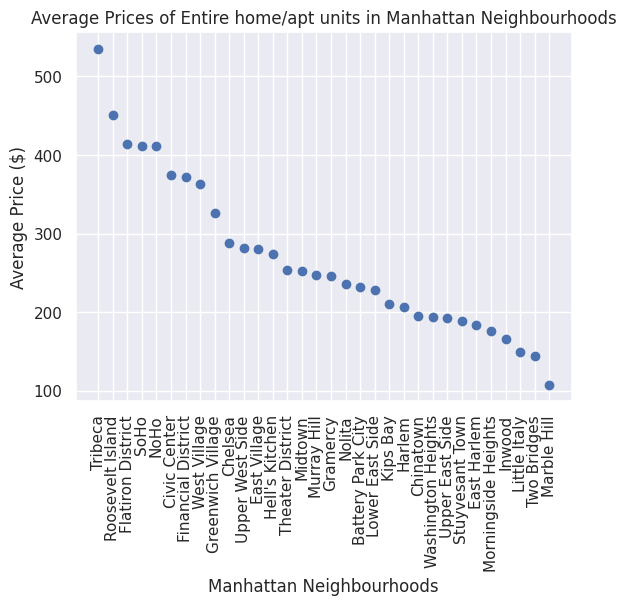

In [13]:
# Filter the dataset to include only listings in Manhattan with 'Entire home/apt' room type
df_manhattan = listings_df[(listings_df['neighbourhood_group'] == 'Manhattan') & (listings_df['room_type'] == 'Entire home/apt')]

# Group by neighborhood and calculate mean prices for 'Entire home/apt' units
df_groups = df_manhattan.groupby('neighbourhood')['price'].mean().sort_values(ascending=False)
mean_prices = list(df_groups)

# Perform one-way ANOVA test to test for statistically significant differences between the mean prices of neighborhoods
statistic, p = f_oneway(*[df_manhattan[df_manhattan['neighbourhood'] == neighborhood]['price'] for neighborhood in df_groups.index])

# Prints the obtained p value
print("P-Value:", p)

# Plot the scatter plot with necessary labels
plt.scatter(df_groups.index, mean_prices)
plt.xticks(rotation=90)
plt.ylabel('Average Price ($)')
plt.xlabel('Manhattan Neighbourhoods')
plt.title('Average Prices of Entire home/apt units in Manhattan Neighbourhoods')
plt.show()

As the p-value (7.9997e-22) is less than the alpha value of 0.05, we can reject the null hypothesis and conclude that there is a significant difference in the prices of Entire home/apt units between Manhattan neighbourhoods. Tribeca is the most expensive location in Manhattan based on the data provided/present for entire home/apts, with an average price of approximately $595. These findings allude to the fact that New York's neighbourhood groups have a varying price range of entire home/apt units throught their neighbourhoods.

### Statistical Method #3

**Null Hypothesis ($H_{0}$) :** The number of reviews of an Airbnb does not have a statistically significant impact on the price of the Airbnb.

**Alternative Hypothesis ($H_{a}$) :** The number of reviews of an Airbnb has a statistically significant impact on the price of the Airbnb.

**Alpha-Value ($a$) :** 0.05

**Confidence level:** 95%

Resource for the method used in the block below! https://www.geeksforgeeks.org/how-to-conduct-a-two-sample-t-test-in-python/

T-statistic: 4.804976232204855
P-value: 1.5585135406409729e-06


/tmp/ipykernel_45295/3053845248.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=listings_df, x="price", y="number_of_reviews", linewidth = 0.5, palette="mako_r", alpha=1)


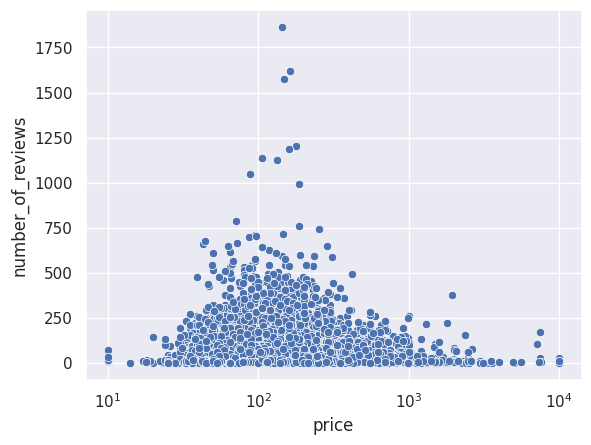

In [14]:
# using a threshold that listings with a number of reviews of lesser than 50 is
# regarded as 'Low' number of reviews and those with higher than 50 is regarded
# as 'High' number of reviews.

# Creates two dataframes split between listings with over 50 reviews and listings with under 50 reviews
low_df = listings_df[listings_df['number_of_reviews'] < 50]
high_df = listings_df[listings_df['number_of_reviews'] >= 50]

# Gets the prices for each dataframe above
low_prices = low_df['price']
high_prices = high_df['price']

# Conducts a t test to obtain a T-statistic and p-value
t_statistic, p_value = ttest_ind(low_prices, high_prices)

print("T-statistic:", t_statistic)
print("P-value:", p_value)

# Plotting the graph with necessary labels
sns.scatterplot(data=listings_df, x="price", y="number_of_reviews", linewidth = 0.5, palette="mako_r", alpha=1)
plt.xscale('log')


The p-value of 1.444e-17 is extremely small, indicating strong evidence against the null hypothesis.

Given the very small p-value, much smaller than the typical significance level of 0.05, we reject the null hypothesis. Therefore, we conclude that there is a statistically significant difference in mean prices between the low and high review groups.

If there's a significant difference in mean prices between listings with low and high review counts, this finding could have implications for pricing strategy. For example, it might suggest that listings with higher review counts can command higher prices, potentially reflecting greater perceived value among customers.

## **Initial Conclusions through Exploratory Analysis**

Through our exploratory data analysis and basic data cleaning (the data was pretty clean to begin with) we hope to build a machine learning model to predict the price of Airbnb listings based on features such as location, property type, number of bedrooms, amenities, and historical booking data. This could help hosts optimize their pricing strategy and maximize their revenue.

Through our aforementioned Hypothesis Testing, we have found correlatory evidence in features provided in the dataset and being able to predict the value of a listing. This provides a positive outlook onto being able to create a Machine Learning pricing model in the future.

# **Primary Analysis**

We used a feed-forward neural network with an input layer, output layer, and one hidden layers. We chose to use the regression strategy because price is not categorical, but continuous. This means that the data analysis needs to give a number value that can come close to the actual value, and not a category. This points to a linear regression, so we've used linear layers in our network.  

In [96]:
# defining the neural network to parse the input data
# three linear layers and the relu function is applied between each
model = nn.Sequential(
    nn.Linear(9, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 1),
).float()

In [97]:
# setting the number of epochs and the batch size for training
n_epochs = 100
batch_size = 20

Here's an article on why we used ReLU: https://www.devron.ai/kbase/relu-over-linear-activation-functions

In [98]:
# define loss function as the Mean Squared Error loss, as this is best for linear regressions
loss_fn = nn.MSELoss()

# use Adam optimizer from pytorch with a learning rate of 0.0001
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# setting up a 80-9-9 training, test, validation split
# the remaining 2% will be used for a logical analysis of the net
train_size = int(0.8 * len(encoded_data))
test_size = int(0.09 * len(encoded_data))
val_size = int(0.09 * len(encoded_data))
analysis_size = int(0.02 * len(encoded_data) + 1)

# randomly split the data into training, testing, validation and analysis data
train_set, test_set, val_set, analysis_set = torch.utils.data.random_split(encoded_data, [train_size, test_size, val_size, analysis_size])

In [99]:
# extract the training data from the full encoded dataset
x_train = encoded_data.iloc[list(train_set.indices)]
# set labels as the values of the price column and standardize values
y_train = x_train['price'].values
# drop the labels from the training data and convert to a numpy array of floats
x_train = x_train.drop('price', axis=1).to_numpy().astype(float)

# repeat above process for testing and validation data

x_test = encoded_data.iloc[list(test_set.indices)]
y_test = x_test['price'].values
x_test = x_test.drop('price', axis=1).to_numpy().astype(float)

x_val = encoded_data.iloc[list(val_set.indices)]
y_val = x_val['price'].values
x_val = x_val.drop('price', axis=1).to_numpy().astype(float)

# make the training, testing, and validation data and values into tensors with floats
x_train = torch.tensor(x_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
x_val = torch.tensor(x_val, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

# keep track of the best model generated by keeping track of the lowest mse
best_mse = np.inf
best_model = None

# create arrays to store both test and eval loss
mse_store = []
loss_store = []
eval_epochs = 0
batch_start = torch.arange(0, len(x_train), batch_size)

# training loop
for epoch in range(n_epochs):

    model.train()

    # go through all start values for batches
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")

        for start in bar:

            # take a batch with the given start size
            X_batch = x_train[start:start+batch_size].float()
            y_batch = y_train[start:start+batch_size].float()

            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)

            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # update weights
            optimizer.step()

            # print progress
            bar.set_postfix(mse=float(loss))

    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(x_val)

    eval_epochs += 1

    mse = loss_fn(y_pred, y_val)

    mse = float(mse)
    mse_store.append(mse)
    loss_store.append(loss.item())

    print(f"Epoch: {epoch}, Train Loss: {loss.item()} Eval Loss: {mse}")

    # check if this is the best model generated so far, store if so
    if mse < best_mse:
        best_mse = mse
        best_model = copy.deepcopy(model.state_dict())

# save best model's weights into model.pth file
model.load_state_dict(best_model)
torch.save(model.state_dict(), "model.pth")

/home/somil/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning:

Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

/home/somil/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning:

Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

/home/somil/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning:

Using a target size (torch.Size([1868])) that is different to the input size (torch.Size([1868, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Epoch: 0, Train Loss: 8344.2119140625 Eval Loss: 175669.90625
Epoch: 1, Train Loss: 7975.13525390625 Eval Loss: 172829.921875
Epoch: 2, Train Loss: 8322.578125 Eval Loss: 172289.578125
Epoch: 3, Train Loss: 8482.3203125 Eval Loss: 171942.109375
Epoch: 4, Train Loss: 8539.6025390625 Eval Loss: 171690.46875
Epoch: 5, Train Loss: 8535.931640625 Eval Loss: 171504.28125
Epoch: 6, Train Loss: 8483.701171875 Eval Loss: 171352.515625
Epoch: 7, Train Loss: 8391.2822265625 Eval Loss: 171220.078125
Epoch: 8, Train Loss: 8276.48828125 Eval Loss: 171107.734375
Epoch: 9, Train Loss: 8148.8828125 Eval Loss: 171014.3125
Epoch: 10, Train Loss: 8023.46630859375 Eval Loss: 170931.28125
Epoch: 11, Train Loss: 7899.29931640625 Eval Loss: 170854.125
Epoch: 12, Train Loss: 7699.6494140625 Eval Loss: 170766.171875
Epoch: 13, Train Loss: 7546.8798828125 Eval Loss: 170700.359375
Epoch: 14, Train Loss: 7399.646484375 Eval Loss: 170639.640625
Epoch: 15, Train Loss: 7261.29052734375 Eval Loss: 170581.375
Epoch: 16

Resources for the methods used in the block above! 

https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html

https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html

https://pytorch.org/docs/stable/optim.html

https://discuss.pytorch.org/t/torch-utils-data-dataset-random-split/32209

### Load model and plot validation



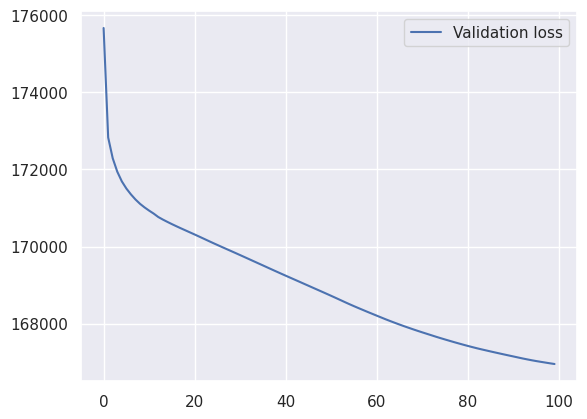

In [100]:
# plot the validation loss
plt.plot(range(eval_epochs), mse_store, label='Validation loss')
plt.legend()
plt.show()

### Find accuracy of model on test data

In [101]:
# set model to inference mode
model.eval()
batch_size = 1
preds = []

# create loader for test data
test_loader = DataLoader(x_test, batch_size=batch_size, shuffle=False)

# evaluation loop; for each element in the test data,
# predict the value and append it to the list of predictions
with torch.no_grad():
  for x in tqdm.tqdm(test_loader):
    y_pred = model(x)
    preds.append(y_pred)

# find mse loss between the predicted values and the actual values
preds = torch.tensor(preds)
mse_loss = nn.MSELoss()
mse = mse_loss(preds, y_test)
print(f"mse: {mse}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1868/1868 [00:00<00:00, 10260.64it/s]

mse: 38294.7421875


# **Visualization**

With such a low MSE **(given that we are NOT normalizing the data and scaling it between 0 and 1)**, we are able to confidently say that our model gives a good reflection of what the ideal price for a given airbnb listing in New York should be based on a given set of features. With this, we set aside 2% of the data in the beginning which we will be reviewing right now to identify listings that are overvalued/undervalued.

This is a function that uses our previous model and for a given input dataframe it outputs a list of predicted prices and actual prices so we can plot them later.

In [102]:
model.load_state_dict(best_model)

def pred_prices(input_df):
    y_input = input_df['price'].values
    x_input = input_df.drop('price', axis=1).to_numpy().astype(float)

    # make the training, testing, and validation data and values into tensors with floats
    x_input = torch.tensor(x_input, dtype=torch.float32)

    # set model to inference mode
    model.eval()
    batch_size = 1
    preds = []
    
    # create loader for test data
    test_loader = DataLoader(x_input, batch_size=batch_size, shuffle=False)
    
    # evaluation loop; for each element in the test data,
    # predict the value and append it to the list of predictions
    with torch.no_grad():
      for x in tqdm.tqdm(test_loader):
        y_pred = model(x)
        preds.append(y_pred.item())
    
    return preds, y_input

Now we bring in our analysis set of 2% data from earlier and turn it into an actual dataframe.

In [23]:
analysis_df = encoded_data.iloc[analysis_set.indices]
analysis_df.head()

,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
17320,0,25,1,220.0,30,79,3.85,1,180,41
39434,0,15,1,260.0,30,2,0.16,1,47,0
27673,0,52,1,166.0,30,100,1.30,1,364,13
27959,1,10,0,138.0,2,8,2.47,36,133,8
25628,2,9,1,167.0,30,10,0.08,3,365,0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 416/416 [00:00<00:00, 8660.58it/s]


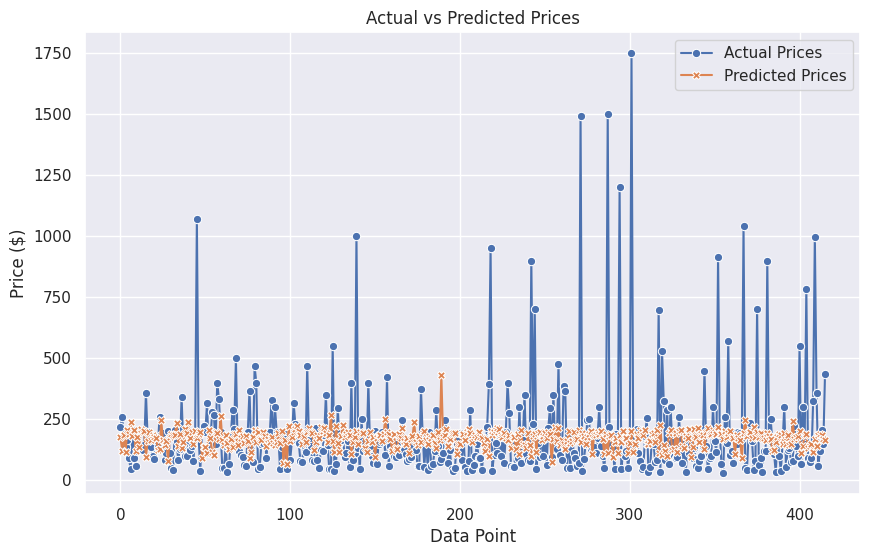

In [110]:
predicted_prices, actual_prices = pred_prices(analysis_df)

sns.set_theme(style="darkgrid")

# Load an example dataset with long-form data
fmri = sns.load_dataset("fmri")

df = pd.DataFrame({'Actual Prices': actual_prices, 'Predicted Prices': predicted_prices})

# Plot the prices using Seaborn lineplot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, markers=True, dashes=False)


plt.title('Actual vs Predicted Prices')
plt.xlabel('Data Point')
plt.ylabel('Price ($)')
plt.show()

Here we can see it becomes easy to identify properties that are overvalued and "bad deals". With a customer running this model we hope they are able to conveniently pick listings better suited to their budget and conversely for listers to better adjust to "current market value" for their properties. 

We can clearly see a lot of the listings are overvalued and some might be good deals. While there is definitely caution to take as our model by no means is perfect but the reader is given a general idea of listings to double check if they are actually getting a good deal. With our model customers and owners can both do a quick check and instantly see results. There is also a case to be made that prices could be sensitive to various external factors such as a Global pandemic or a struggling job market affecting the demand for AirBnBs thus we cannot solely use this model.

# **Insights and Conclusions**:

Through our analysis and price modeling, we found that there was a high correlation between the neighbourhood and neighbourhood groups where the Airbnb was listed and the price of the listing. Through this, we can observe that throughout New York City, certain neighbourhood/neighbourhood groups have more expensive listings and Airbnbs than some other neighbourhoods. For example, when comparing Manhattan neighbourhoods, we found that there were significant differences, with Tribeca having an average listing of approximately 600 whereas Marble Hill has an average listing of approximately 100. In addition, we were able to conclude that there was a correlation between the number of reviews on the listing and the price of the listing. 

This is interesting because it has several meanings in the context of Airbnbs. For example, if users are especially discontent with an Airbnb, there could be more reviews expressing their negative opinions with negative feelings being stronger than positive feelings (Negativity bias). In contrast, an exceptional Airbnb could elicit more positive reviews expressing their positive opinions about the Airbnb. With an existing correlation with the price, this feature was a viable aspect to consider when constructing the model. Another feature we explored was the availability between neighbourhood groups. Once again, we discovered a correlation strong enough to reject the null hypothesis. With the disproportionate availablities between neighbourhood groups, this was another feature that would benefit the model. 

The price model that we have formulated produces a price estimate based on the features, location, etc. of the Airbnb, which can help hosts determine the optimal price for the Airbnb they are listing. Of course, there may be more factors to consider when determining the price of an Airbnb, but our model hopes to provide a benchmark to aid hosts trying to accurately value an Airbnb.